In [ ]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from google.colab import drive

# ✅ 挂载 Google Drive
drive.mount('/content/drive')


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing 401-600: 100%|██████████| 60/60 [00:00<00:00, 10999.05it/s]


✅ 正样本 token 数量: 36447
✅ 负样本 token 数量: 41255


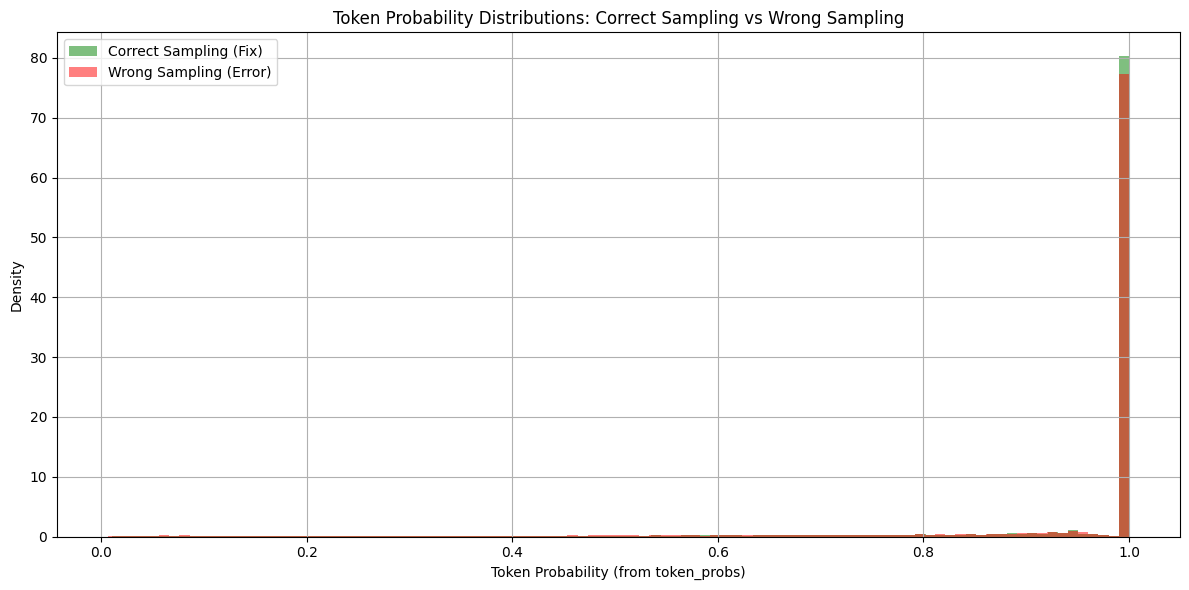

In [ ]:

# ✅ 参数配置
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
intervals = [(201, 300), (301, 400), (401, 600)]
samplings = ['sampling0', 'sampling1', 'sampling2']

# ✅ 初始化容器
all_probs_fix = []
all_probs_error = []

for start, end in intervals:
    range_tag = f"{start}-{end}"
    logits_file = os.path.join(BASE_PATH, f"output/llm_steps/original/deepseek7b-math-{range_tag}_with_steps_reformatted_renumbered.json")
    steps_file = os.path.join(BASE_PATH, f"output/identify_error_step/0524/step_comparison_deepseek7b-math-{range_tag}.json")

    if not os.path.exists(logits_file) or not os.path.exists(steps_file):
        print(f"⚠️ 文件不存在: {range_tag}")
        continue

    # ✅ 读取数据
    with open(logits_file, 'r') as f:
        logits_data = json.load(f)
    with open(steps_file, 'r') as f:
        steps_data = json.load(f)

    # ✅ 直接用 token_probs 字段提取所有概率
    for qid, entry in tqdm(steps_data.items(), desc=f"Processing {range_tag}"):
        if qid == "omitted":
            continue

        for s_type in ['correct_sampling', 'wrong_sampling']:
            for sampling_key in entry.get(s_type, {}):
                if sampling_key in logits_data[qid] and 'token_probs' in logits_data[qid][sampling_key]:
                    token_probs = logits_data[qid][sampling_key]['token_probs']
                    # 只取第二个元素（概率值）
                    probs = [p[1] for p in token_probs if isinstance(p, list) and len(p) == 2]
                    if not probs:
                        continue
                    if s_type == "correct_sampling":
                        all_probs_fix.extend(probs)
                    else:
                        all_probs_error.extend(probs)

print(f"✅ 正样本 token 数量: {len(all_probs_fix)}")
print(f"✅ 负样本 token 数量: {len(all_probs_error)}")

# ✅ 转为 numpy 数组
all_probs_fix = np.array(all_probs_fix)
all_probs_error = np.array(all_probs_error)

# ✅ 绘制直方图对比
plt.figure(figsize=(12, 6))
plt.hist(all_probs_fix, bins=100, alpha=0.5, label='Correct Sampling (Fix)', color='green', density=True)
plt.hist(all_probs_error, bins=100, alpha=0.5, label='Wrong Sampling (Error)', color='red', density=True)
plt.xlabel('Token Probability (from token_probs)')
plt.ylabel('Density')
plt.title('Token Probability Distributions: Correct Sampling vs Wrong Sampling')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


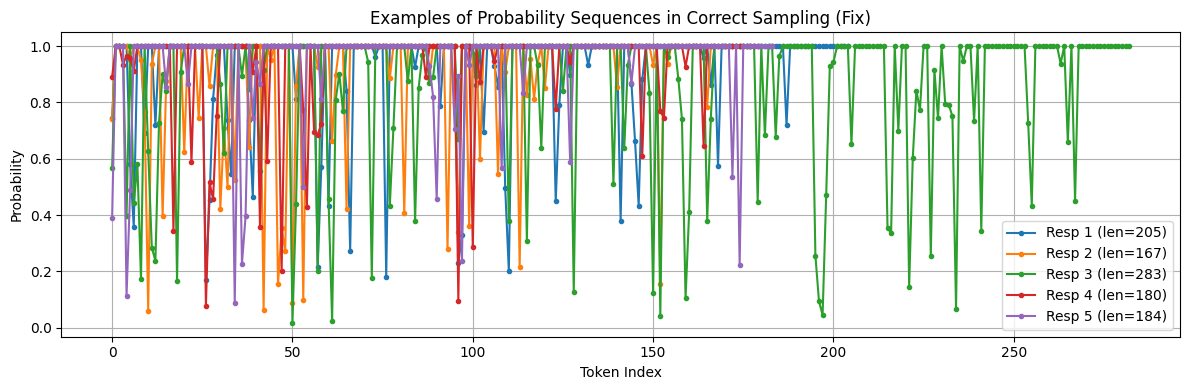

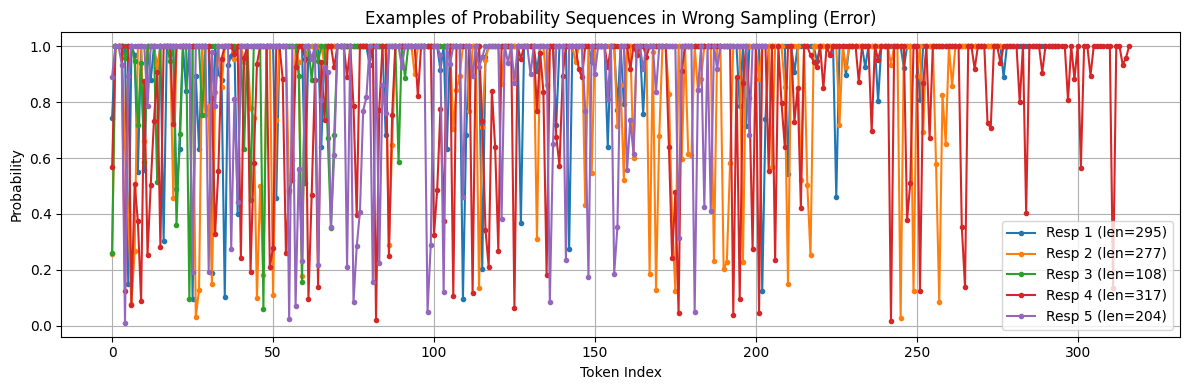

In [8]:
# ✅ 单独可视化：每个回答内的概率序列（正负样本各取 5 个看看形状）

# 👉 先重新提取每个回答的概率序列（分别保存）
responses_fix = []
responses_error = []

for start, end in intervals:
    range_tag = f"{start}-{end}"
    logits_file = os.path.join(BASE_PATH, f"output/llm_steps/original/deepseek7b-math-{range_tag}_with_steps_reformatted_renumbered.json")
    steps_file = os.path.join(BASE_PATH, f"output/identify_error_step/0524/step_comparison_deepseek7b-math-{range_tag}.json")

    if not os.path.exists(logits_file) or not os.path.exists(steps_file):
        continue

    with open(logits_file, 'r') as f:
        logits_data = json.load(f)
    with open(steps_file, 'r') as f:
        steps_data = json.load(f)

    for qid, entry in steps_data.items():
        if qid == "omitted":
            continue
        for s_type in ['correct_sampling', 'wrong_sampling']:
            for sampling_key in entry.get(s_type, {}):
                if sampling_key in logits_data[qid] and 'token_probs' in logits_data[qid][sampling_key]:
                    token_probs = logits_data[qid][sampling_key]['token_probs']
                    probs = [p[1] for p in token_probs if isinstance(p, list) and len(p) == 2]
                    if not probs:
                        continue
                    if s_type == "correct_sampling":
                        responses_fix.append(probs)
                    else:
                        responses_error.append(probs)

# ✅ 绘制正样本的 5 个回答
plt.figure(figsize=(12, 4))
for i, probs in enumerate(responses_fix[:5]):
    plt.plot(range(len(probs)), probs, marker='.', label=f"Resp {i+1} (len={len(probs)})")
plt.xlabel('Token Index')
plt.ylabel('Probability')
plt.title('Examples of Probability Sequences in Correct Sampling (Fix)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ✅ 绘制负样本的 5 个回答
plt.figure(figsize=(12, 4))
for i, probs in enumerate(responses_error[:5]):
    plt.plot(range(len(probs)), probs, marker='.', label=f"Resp {i+1} (len={len(probs)})")
plt.xlabel('Token Index')
plt.ylabel('Probability')
plt.title('Examples of Probability Sequences in Wrong Sampling (Error)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


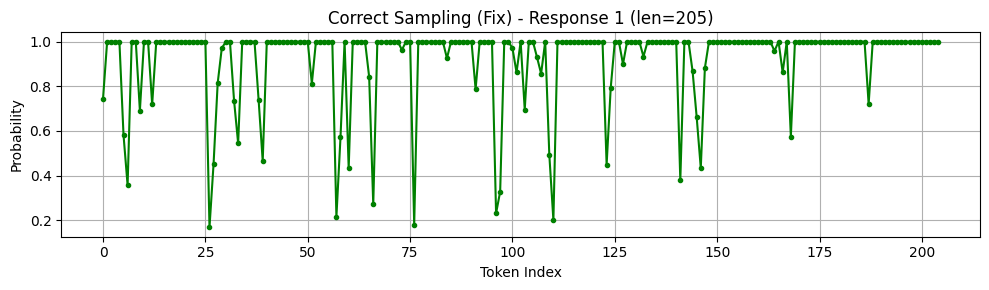

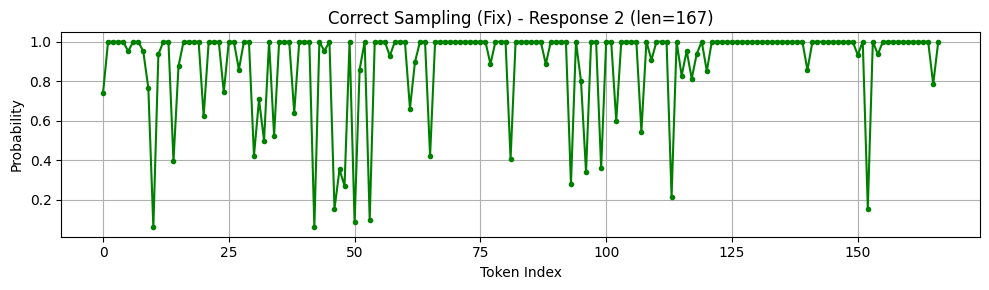

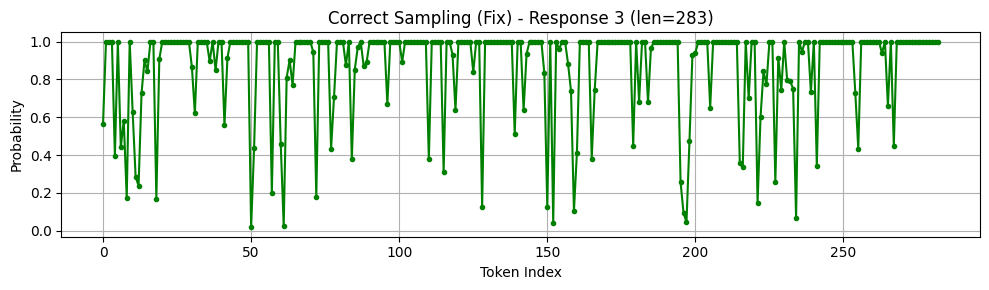

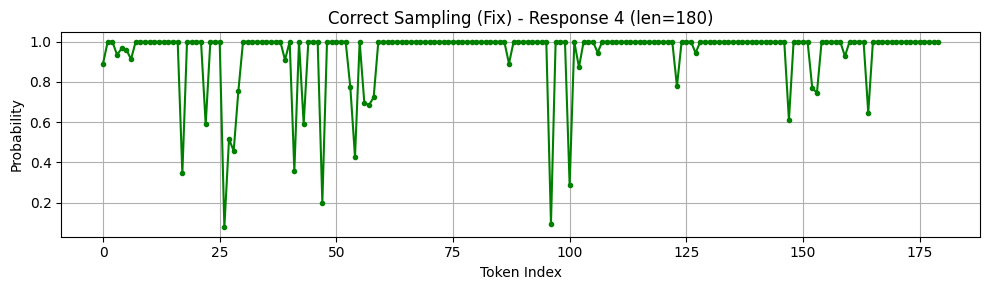

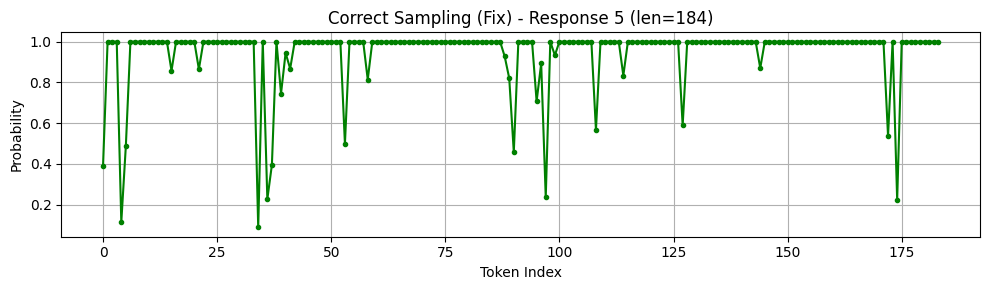

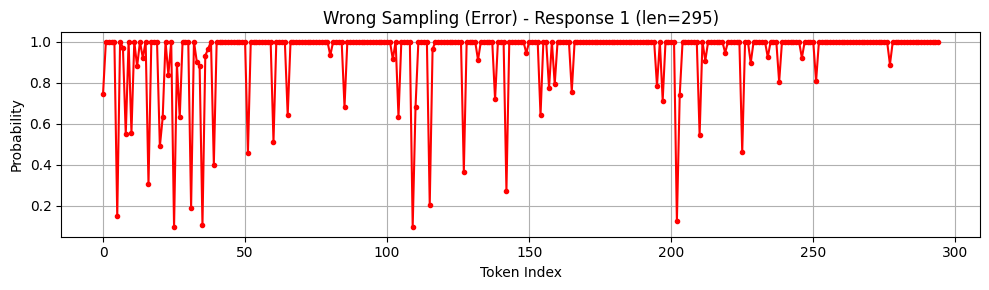

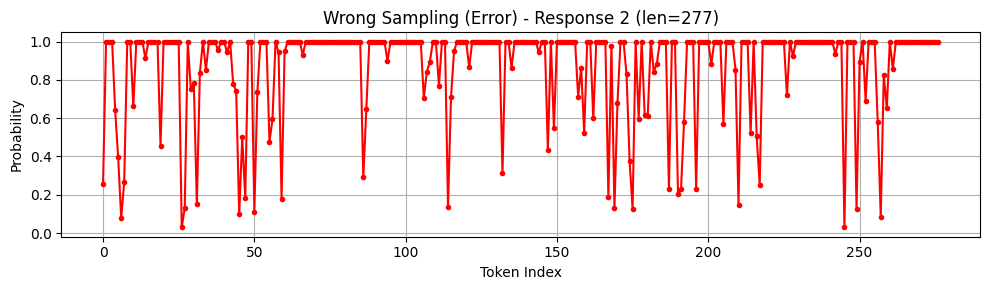

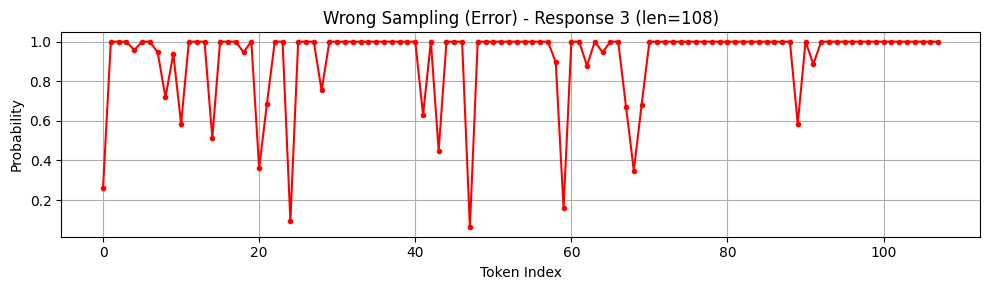

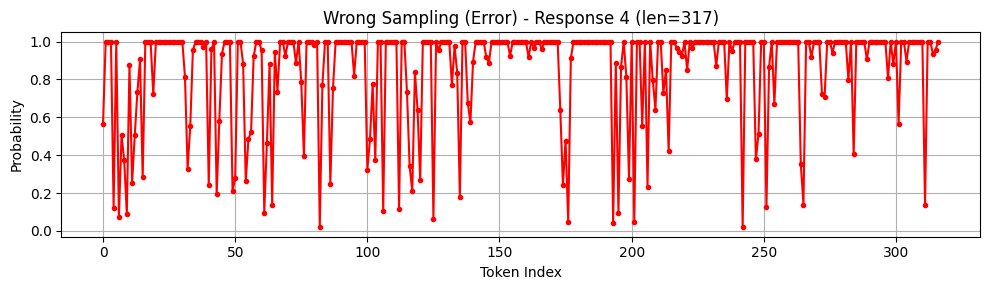

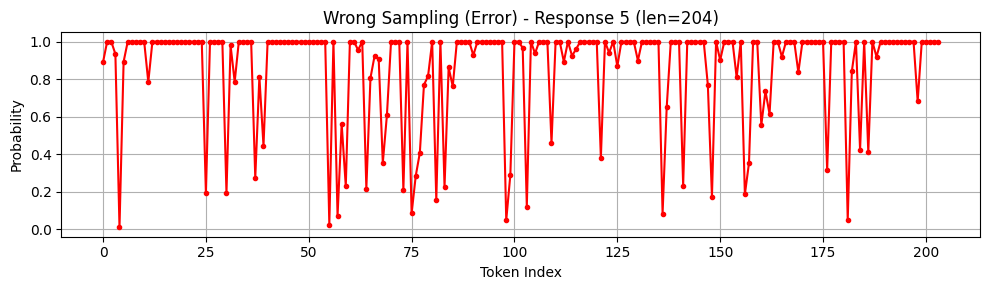

In [9]:
# ✅ 绘制正样本的前 5 个回答，每个回答单独成图
for i, probs in enumerate(responses_fix[:5]):
    plt.figure(figsize=(10, 3))
    plt.plot(range(len(probs)), probs, marker='.', color='green')
    plt.xlabel('Token Index')
    plt.ylabel('Probability')
    plt.title(f'Correct Sampling (Fix) - Response {i+1} (len={len(probs)})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# ✅ 绘制负样本的前 5 个回答，每个回答单独成图
for i, probs in enumerate(responses_error[:5]):
    plt.figure(figsize=(10, 3))
    plt.plot(range(len(probs)), probs, marker='.', color='red')
    plt.xlabel('Token Index')
    plt.ylabel('Probability')
    plt.title(f'Wrong Sampling (Error) - Response {i+1} (len={len(probs)})')
    plt.grid(True)
    plt.tight_layout()
    plt.show()


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing 401-600: 100%|██████████| 60/60 [00:00<00:00, 3959.57it/s]


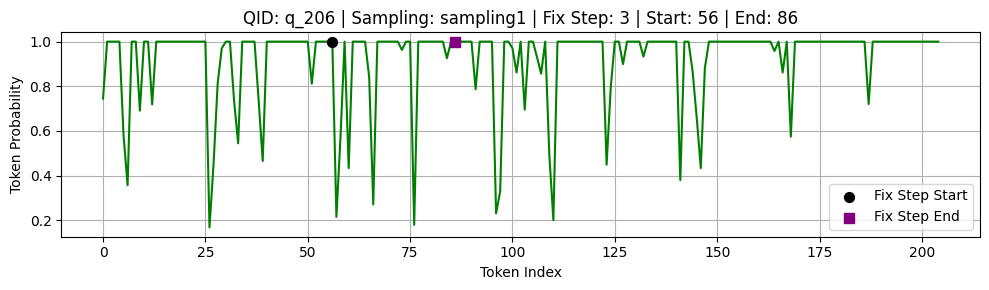

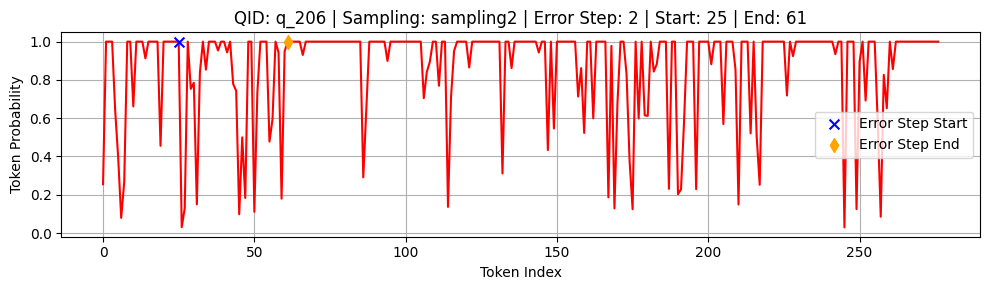

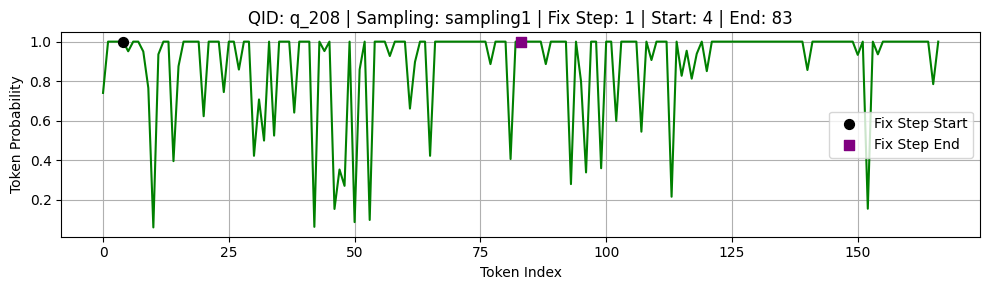

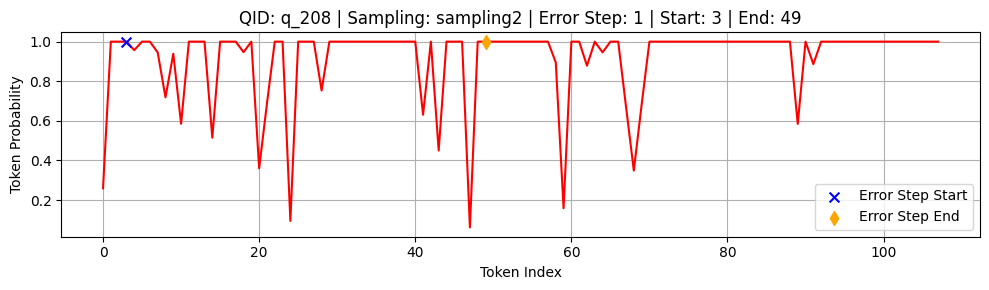

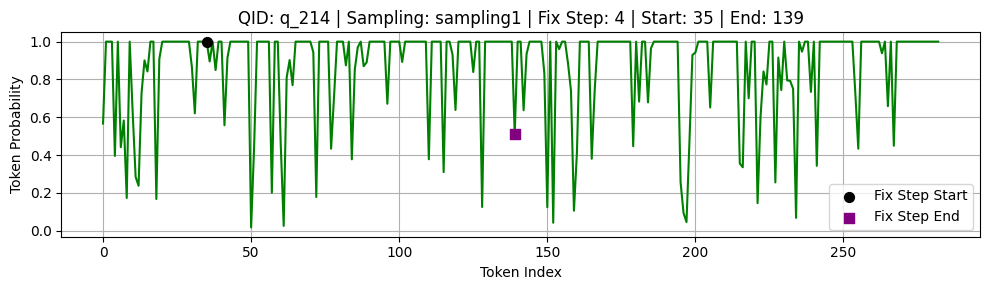

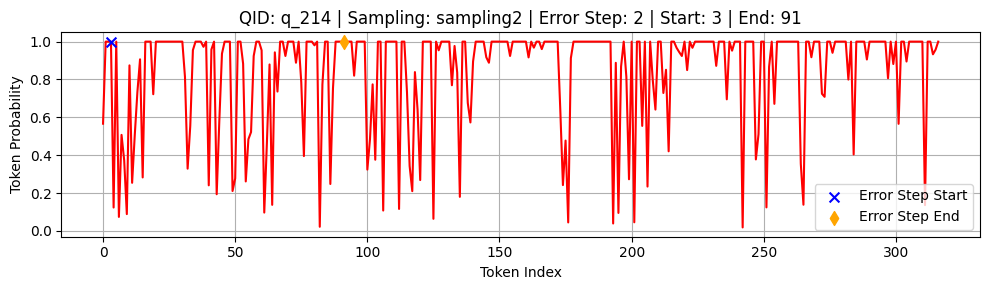

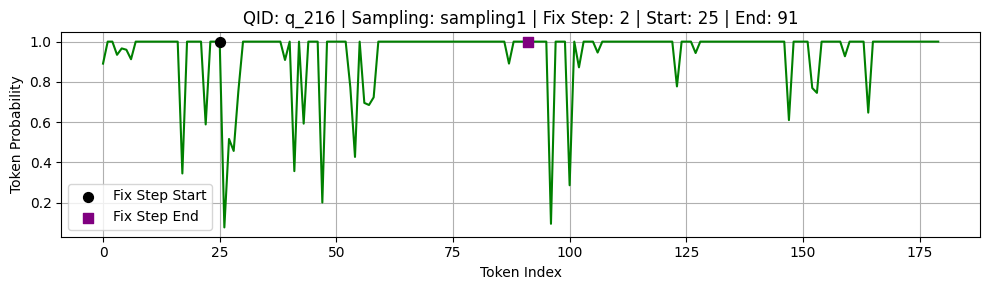

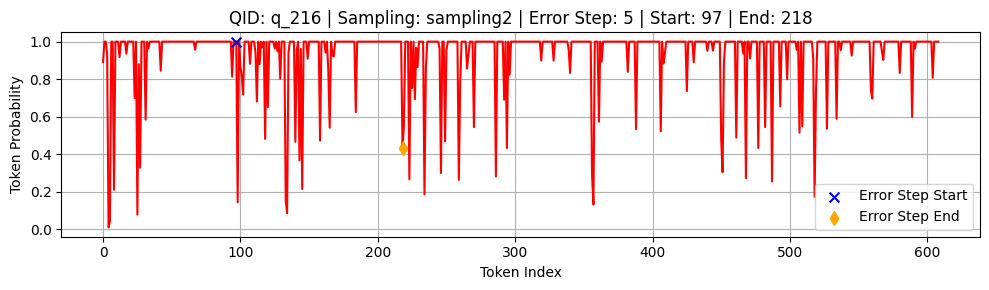

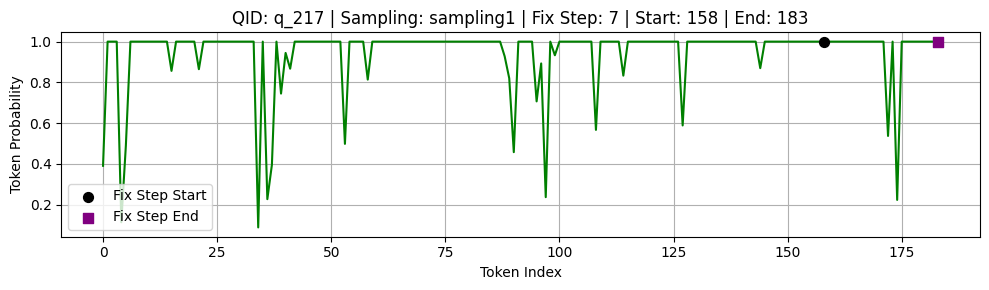

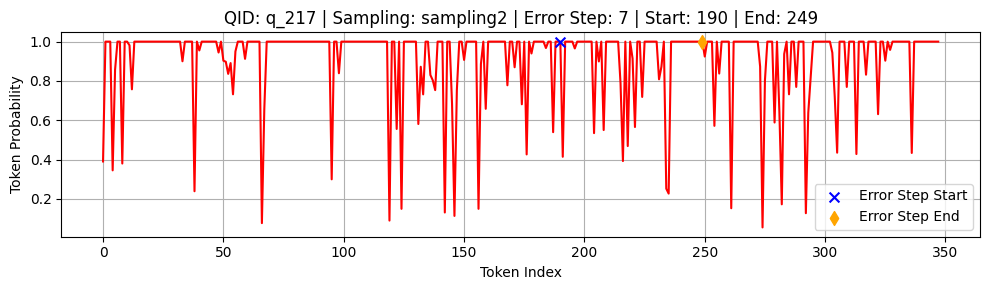

✅ 所有图片绘制完成！


In [18]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from google.colab import drive

# ✅ 挂载 Google Drive
drive.mount('/content/drive')

# ========== 📂 配置 ==========
intervals = [(201, 300), (301, 400), (401, 600)]
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
OUTPUT_DIR = os.path.join(BASE_PATH, "output/stat_logits/0524")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ========== 📊 存储正负样本 response ==========
samples_by_qid = {}

for start_index, end_index in intervals:
    range_tag = f"{start_index}-{end_index}"
    INFERENCE_PATH = os.path.join(BASE_PATH, f"output/llm_steps/original/deepseek7b-math-{range_tag}_with_steps_reformatted_renumbered.json")
    STEPS_PATH = os.path.join(BASE_PATH, f"output/identify_error_step/0524/step_comparison_deepseek7b-math-{range_tag}.json")

    if not os.path.exists(INFERENCE_PATH) or not os.path.exists(STEPS_PATH):
        continue

    with open(INFERENCE_PATH, 'r') as f:
        logits_data = json.load(f)
    with open(STEPS_PATH, 'r') as f:
        steps_data = json.load(f)

    for qid, entry in tqdm(steps_data.items(), desc=f"Processing {range_tag}"):
        if qid == "omitted":
            continue

        for s_type in ['correct_sampling', 'wrong_sampling']:
            for sampling_key, comparisons in entry.get(s_type, {}).items():
                for vs_key, info in comparisons.items():
                    step_key = "fix_step" if s_type == "correct_sampling" else "error_step"
                    if step_key in info:
                        step = str(info[step_key])
                        token_probs = logits_data[qid][sampling_key].get("token_probs", [])
                        full_tokens = [p[0] for p in token_probs if isinstance(p, list) and len(p) == 2]
                        probs = [p[1] for p in token_probs if isinstance(p, list) and len(p) == 2]

                        step_token_probs = logits_data[qid][sampling_key].get("step_token_probs", {})
                        step_tokens = step_token_probs.get(step, None)
                        if step_tokens is None:
                            try:
                                step_tokens = step_token_probs.get(int(step), None)
                            except Exception:
                                step_tokens = None

                        if not step_tokens:
                            continue

                        # 子串匹配找 step_index
                        step_tokens_text = [d["token"] for d in step_tokens[:5]]
                        found = False
                        for i in range(len(full_tokens) - len(step_tokens_text) + 1):
                            if full_tokens[i:i+len(step_tokens_text)] == step_tokens_text:
                                step_index = i
                                found = True
                                break
                        if not found:
                            continue

                        # 计算 step 结束位置 index
                        step_end_index = step_index + len(step_tokens) - 1

                        sample = {
                            "qid": qid,
                            "probs": probs,
                            "step_index": step_index,
                            "step_end_index": step_end_index,
                            "sampling_id": sampling_key,
                            "type": "fix" if s_type == "correct_sampling" else "error",
                            "step": step
                        }

                        if qid not in samples_by_qid:
                            samples_by_qid[qid] = {}
                        samples_by_qid[qid][s_type] = sample

# ✅ 只取前 5 个 question，依次绘制 correct 和 wrong
for idx, (qid, samples) in enumerate(list(samples_by_qid.items())[:5]):
    # 绘制 fix step
    if "correct_sampling" in samples:
        sample = samples["correct_sampling"]
        plt.figure(figsize=(10, 3))
        plt.plot(range(len(sample["probs"])), sample["probs"], color='green')
        plt.scatter(sample["step_index"], sample["probs"][sample["step_index"]], color='black', marker='o', s=50, zorder=5, label='Fix Step Start')
        plt.scatter(sample["step_end_index"], sample["probs"][sample["step_end_index"]], color='purple', marker='s', s=50, zorder=5, label='Fix Step End')
        plt.xlabel('Token Index')
        plt.ylabel('Token Probability')
        plt.title(f'QID: {qid} | Sampling: {sample["sampling_id"]} | Fix Step: {sample["step"]} | Start: {sample["step_index"]} | End: {sample["step_end_index"]}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

    # 绘制 error step
    if "wrong_sampling" in samples:
        sample = samples["wrong_sampling"]
        plt.figure(figsize=(10, 3))
        plt.plot(range(len(sample["probs"])), sample["probs"], color='red')
        plt.scatter(sample["step_index"], sample["probs"][sample["step_index"]], color='blue', marker='x', s=50, zorder=5, label='Error Step Start')
        plt.scatter(sample["step_end_index"], sample["probs"][sample["step_end_index"]], color='orange', marker='d', s=50, zorder=5, label='Error Step End')
        plt.xlabel('Token Index')
        plt.ylabel('Token Probability')
        plt.title(f'QID: {qid} | Sampling: {sample["sampling_id"]} | Error Step: {sample["step"]} | Start: {sample["step_index"]} | End: {sample["step_end_index"]}')
        plt.legend()
        plt.grid(True)
        plt.tight_layout()
        plt.show()

print("✅ 所有图片绘制完成！")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Processing 401-600: 100%|██████████| 60/60 [00:00<00:00, 2395.76it/s]


✅ 样本解析完毕！


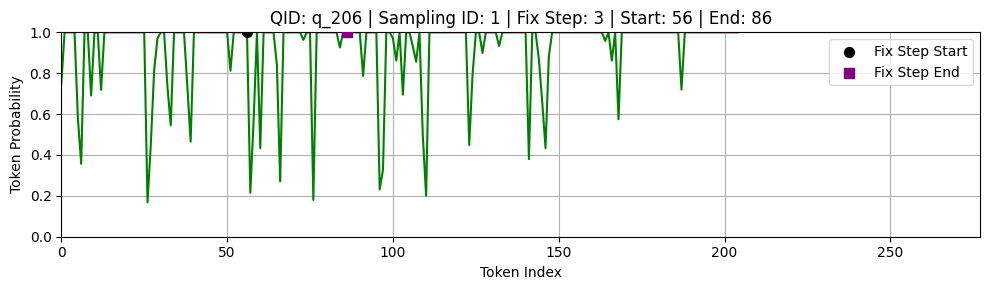

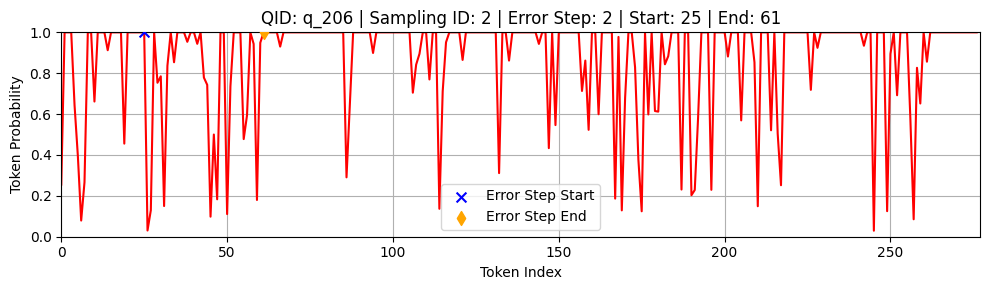

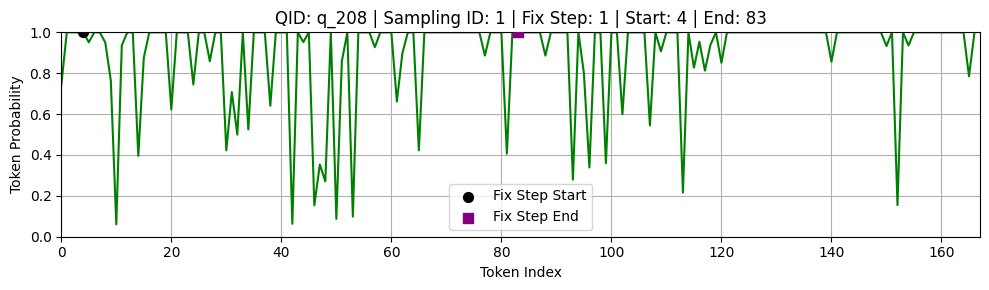

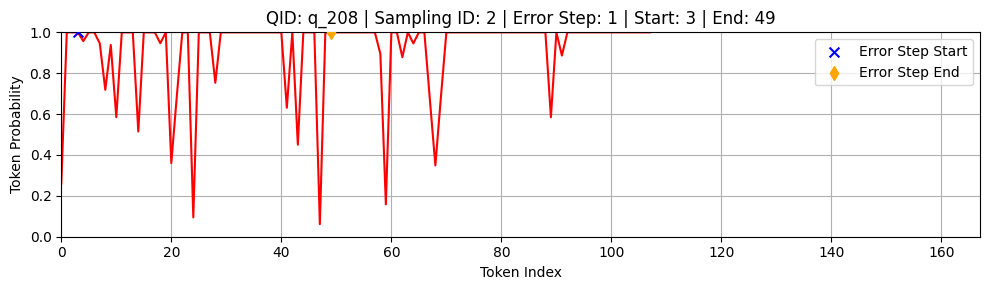

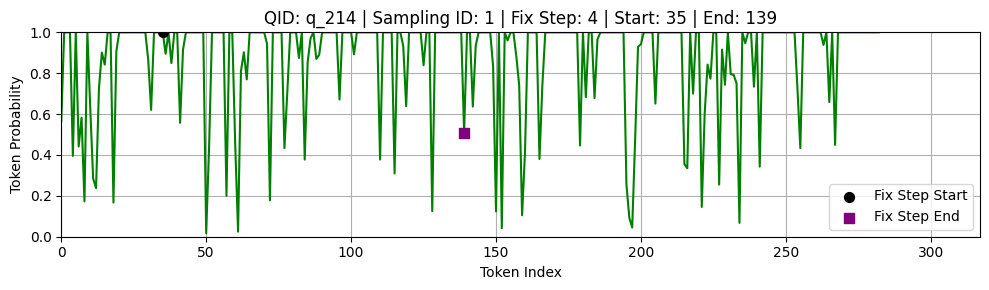

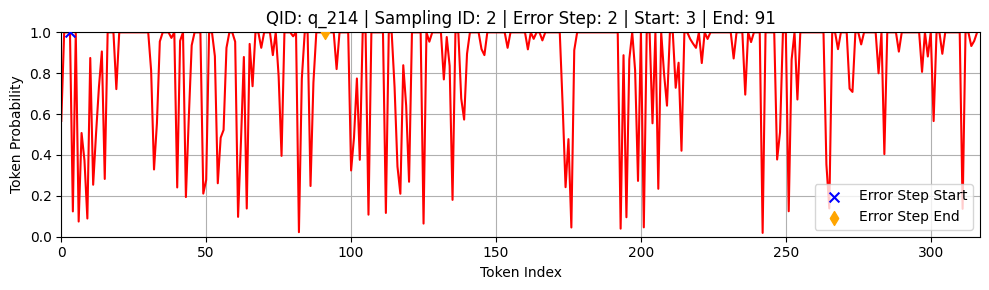

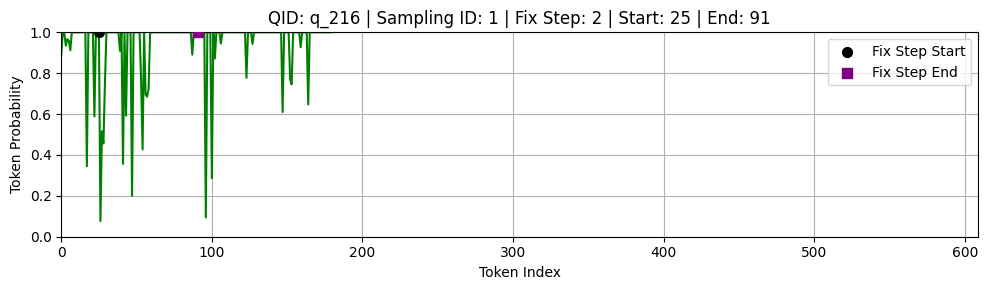

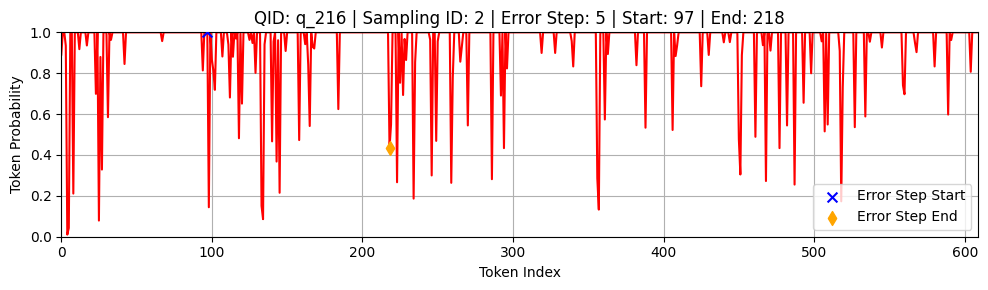

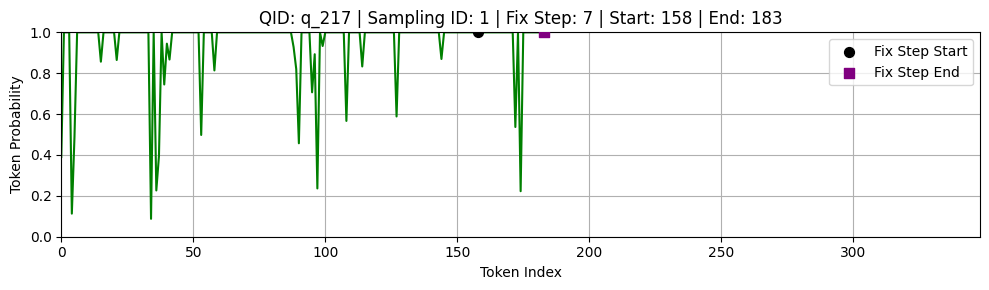

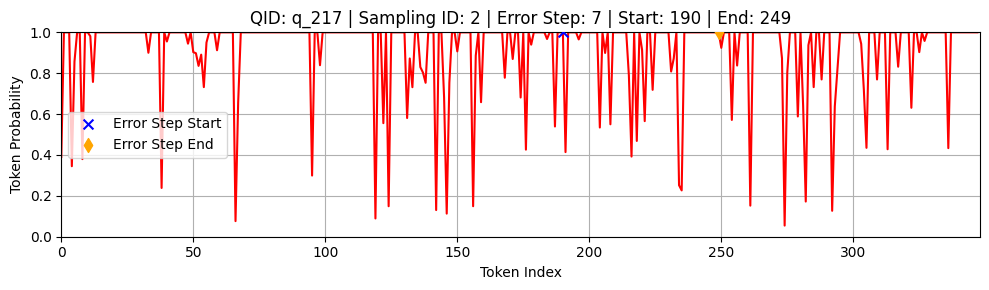

✅ 所有图片绘制完成，横坐标在同一 qid 内已统一，且显示真实 sampling id！


In [22]:
import json
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm import tqdm
from google.colab import drive

# ✅ 挂载 Google Drive
drive.mount('/content/drive')

# ========== 📂 配置 ==========
intervals = [(201, 300), (301, 400), (401, 600)]
BASE_PATH = "/content/drive/MyDrive/Cluster-proj"
OUTPUT_DIR = os.path.join(BASE_PATH, "output/stat_logits/0524")
os.makedirs(OUTPUT_DIR, exist_ok=True)

# ========== 📊 存储正负样本 response ==========
samples_by_qid = {}

for start_index, end_index in intervals:
    range_tag = f"{start_index}-{end_index}"
    INFERENCE_PATH = os.path.join(BASE_PATH, f"output/llm_steps/original/deepseek7b-math-{range_tag}_with_steps_reformatted_renumbered.json")
    STEPS_PATH = os.path.join(BASE_PATH, f"output/identify_error_step/0524/step_comparison_deepseek7b-math-{range_tag}.json")

    if not os.path.exists(INFERENCE_PATH) or not os.path.exists(STEPS_PATH):
        continue

    with open(INFERENCE_PATH, 'r') as f:
        logits_data = json.load(f)
    with open(STEPS_PATH, 'r') as f:
        steps_data = json.load(f)

    for qid, entry in tqdm(steps_data.items(), desc=f"Processing {range_tag}"):
        if qid == "omitted":
            continue

        for s_type in ['correct_sampling', 'wrong_sampling']:
            for sampling_key, comparisons in entry.get(s_type, {}).items():
                for vs_key, info in comparisons.items():
                    step_key = "fix_step" if s_type == "correct_sampling" else "error_step"
                    if step_key in info:
                        step = str(info[step_key])
                        token_probs = logits_data[qid][sampling_key].get("token_probs", [])
                        full_tokens = [p[0] for p in token_probs if isinstance(p, list) and len(p) == 2]
                        probs = [p[1] for p in token_probs if isinstance(p, list) and len(p) == 2]

                        step_token_probs = logits_data[qid][sampling_key].get("step_token_probs", {})
                        step_tokens = step_token_probs.get(step, None)
                        if step_tokens is None:
                            try:
                                step_tokens = step_token_probs.get(int(step), None)
                            except Exception:
                                step_tokens = None

                        if not step_tokens:
                            continue

                        # 子串匹配找 step_index
                        step_tokens_text = [d["token"] for d in step_tokens[:5]]
                        found = False
                        for i in range(len(full_tokens) - len(step_tokens_text) + 1):
                            if full_tokens[i:i+len(step_tokens_text)] == step_tokens_text:
                                step_index = i
                                found = True
                                break
                        if not found:
                            continue

                        # 计算 step 结束位置 index
                        step_end_index = step_index + len(step_tokens) - 1

                        # ✅ 提取真实 sampling id（0/1/2）
                        sampling_id_num = int(sampling_key.replace("sampling", ""))

                        sample = {
                            "qid": qid,
                            "probs": probs,
                            "step_index": step_index,
                            "step_end_index": step_end_index,
                            "sampling_id": sampling_id_num,  # ✅ 真实 id
                            "type": "fix" if s_type == "correct_sampling" else "error",
                            "step": step
                        }

                        if qid not in samples_by_qid:
                            samples_by_qid[qid] = {}
                        samples_by_qid[qid][s_type] = sample

print("✅ 样本解析完毕！")

# ✅ 只取前 5 个 question，依次绘制 correct 和 wrong
for idx, (qid, samples) in enumerate(list(samples_by_qid.items())[:5]):
    # 计算同一个 qid 下 fix & error 的最大 token 序列长度
    max_x_local = 0
    for s_type in ['correct_sampling', 'wrong_sampling']:
        if s_type in samples:
            max_x_local = max(max_x_local, len(samples[s_type]["probs"]))

    # 绘制 fix step
    if "correct_sampling" in samples:
        sample = samples["correct_sampling"]
        plt.figure(figsize=(10, 3))
        plt.plot(range(len(sample["probs"])), sample["probs"], color='green')
        plt.scatter(sample["step_index"], sample["probs"][sample["step_index"]], color='black', marker='o', s=50, zorder=5, label='Fix Step Start')
        plt.scatter(sample["step_end_index"], sample["probs"][sample["step_end_index"]], color='purple', marker='s', s=50, zorder=5, label='Fix Step End')
        plt.xlabel('Token Index')
        plt.ylabel('Token Probability')
        plt.title(f'QID: {qid} | Sampling ID: {sample["sampling_id"]} | Fix Step: {sample["step"]} | Start: {sample["step_index"]} | End: {sample["step_end_index"]}')
        plt.legend()
        plt.grid(True)
        # ✅ 使用当前 qid 最大 token index
        plt.xlim(0, max_x_local)
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()

    # 绘制 error step
    if "wrong_sampling" in samples:
        sample = samples["wrong_sampling"]
        plt.figure(figsize=(10, 3))
        plt.plot(range(len(sample["probs"])), sample["probs"], color='red')
        plt.scatter(sample["step_index"], sample["probs"][sample["step_index"]], color='blue', marker='x', s=50, zorder=5, label='Error Step Start')
        plt.scatter(sample["step_end_index"], sample["probs"][sample["step_end_index"]], color='orange', marker='d', s=50, zorder=5, label='Error Step End')
        plt.xlabel('Token Index')
        plt.ylabel('Token Probability')
        plt.title(f'QID: {qid} | Sampling ID: {sample["sampling_id"]} | Error Step: {sample["step"]} | Start: {sample["step_index"]} | End: {sample["step_end_index"]}')
        plt.legend()
        plt.grid(True)
        # ✅ 使用当前 qid 最大 token index
        plt.xlim(0, max_x_local)
        plt.ylim(0, 1)
        plt.tight_layout()
        plt.show()

print("✅ 所有图片绘制完成，横坐标在同一 qid 内已统一，且显示真实 sampling id！")
